In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sys, os, glob, json, re
import pygaze
# import GazeParser
from helpers import *
from tqdm import tqdm

In [2]:
sys.path.append('pygazeanalyser')

In [3]:
import gazeplotter, opengazereader, idfreader, eyetribereader, edfreader, detectors, traces

In [4]:
from gazeplotter import parse_fixations, gaussian

In [5]:
base_dir = '%s/Dropbox (Brown)/Postdoc FHL/JEROEN/SOC_STRUCT_LEARN'%os.environ['HOME']

## Look at one subject

In [6]:
sub = 5

##### Raw data

In [7]:
gaze_data_trials = parse_trials(load_data(sub, base_dir = base_dir))
gaze_data_trials.head()

Loading files:
/Users/jvanbaar/Dropbox (Brown)/Postdoc FHL/JEROEN/SOC_STRUCT_LEARN/Study2_EyeTracking/Data/Cleaned/Gaze_full_info/sub-005_ses-001_part1 Samples.txt
/Users/jvanbaar/Dropbox (Brown)/Postdoc FHL/JEROEN/SOC_STRUCT_LEARN/Study2_EyeTracking/Data/Cleaned/Gaze_full_info/sub-005_ses-001_part2 Samples.txt
Raw data shape is (97839, 8)
Raw data shape is (74476, 8)
Processed data shape is (172154, 12)


,time,L_diam,R_diam,L_X,L_Y,R_X,R_Y,dt,sub,chunk,session,part,trial_row,block,trial,S,T
7180,1733390405842,3.54,3.62,253.76,937.21,215.39,931.24,62074.596,5,"Starting block 1 trial 1, S = 0 and T = 12",1,1,True,1,1,0,12
7181,1733390414209,3.54,3.62,253.05,939.17,209.90,932.29,62082.963,5,"Starting block 1 trial 1, S = 0 and T = 12",1,1,True,1,1,0,12
7182,1733390422591,3.54,3.63,254.66,941.33,220.79,932.57,62091.345,5,"Starting block 1 trial 1, S = 0 and T = 12",1,1,True,1,1,0,12
7183,1733390430948,3.54,3.63,252.05,941.05,222.75,931.99,62099.702,5,"Starting block 1 trial 1, S = 0 and T = 12",1,1,True,1,1,0,12
7184,1733390439199,3.55,3.63,248.47,941.38,223.55,931.71,62107.953,5,"Starting block 1 trial 1, S = 0 and T = 12",1,1,True,1,1,0,12


##### Fixation events

In [8]:
fixation_events = load_fixations(sub)
fixation_events.head()

Loading files:
/Users/jvanbaar/Dropbox (Brown)/Postdoc FHL/JEROEN/SOC_STRUCT_LEARN/Study2_EyeTracking/Data/Cleaned/Gaze_events/sub-005_ses-001_part1 Events.txt
/Users/jvanbaar/Dropbox (Brown)/Postdoc FHL/JEROEN/SOC_STRUCT_LEARN/Study2_EyeTracking/Data/Cleaned/Gaze_events/sub-005_ses-001_part2 Events.txt
[1, 1] [1, 2]
Raw data shape is (10812, 17)
Raw data shape is (9017, 17)


,event_type,tracker_trial,number,start,end,duration,X,Y,disp_X,disp_Y,plane,avg_pupil_X,avg_pupil_Y,file_index
0,Fixation L,1,1,1733351806245,1733352006492,200247,156.92,793.45,37.0,35.0,-1,12.47,12.47,0
1,Fixation L,1,2,1733352048255,1733352181779,133524,647.91,440.48,20.0,49.0,-1,12.30,12.30,0
2,Fixation L,1,3,1733352198389,1733352365277,166888,468.06,268.64,56.0,29.0,-1,12.08,12.08,0
3,Fixation L,1,4,1733352373522,1733353216152,842630,412.50,226.11,22.0,76.0,-1,12.15,12.15,0
4,Fixation L,1,5,1733353224553,1733354108790,884237,421.80,255.74,44.0,53.0,-1,12.62,12.62,0


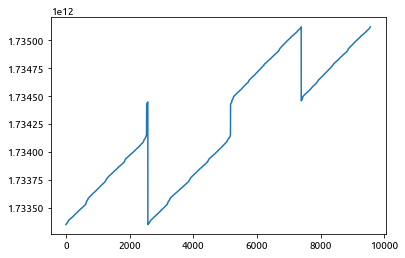

In [9]:
fixation_events['start'].plot()

Should see at least four positive-slope line segments here: eye L and R for the first part, then eye L and R for the second part. For subjects with more calibrations between blocks, more lines should appear (but shorter ones).

##### Plot a few trials

12

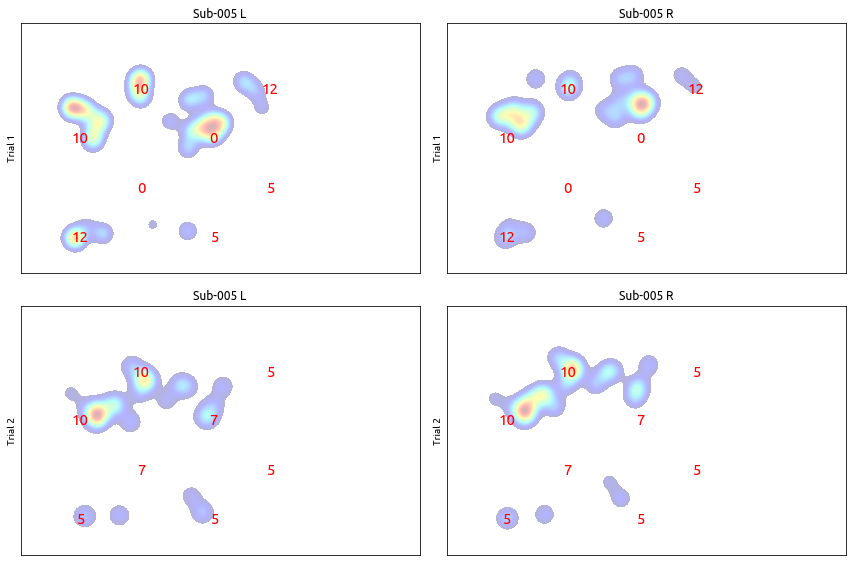

In [11]:
dispsize = [1680, 1050]
dpi = 150

trials = np.arange(1,3)
eyes = ['L','R']

fig, axes = plt.subplots(len(trials), len(eyes), figsize = [12,4*len(trials)])

for ti, trial in enumerate(trials):
    print(trial, end = '')
    for ei,eye in enumerate(eyes):
        ax = axes[ti,ei]
        S, T = gaze_data_trials.query('trial == @trial')[['S','T']].drop_duplicates().values[0]
        fix = select_trial_fixations(trial, gaze_data_trials, fixation_events, eye = eye)
        fix = fix.loc[(fix['X'] >= 200) & (fix['X'] <= 1120) &
                      (fix['Y'] >= 200) & (fix['Y'] <= 950),:].reset_index(drop=True)
        fix_dict = parse_fixations(fix.values)
        hm = get_heatmap(fix_dict, dispsize = dispsize)
        plot_heatmap(hm, dispsize, ax = ax, draw_numbers = True, remove_zeros = True, S = S, T = T,
                    alpha = 0.3)
        ax.set(title = 'Sub-%03d %s'%(sub,eye), ylabel = 'Trial %i'%trial)
        ax.invert_yaxis()
plt.tight_layout()
# plt.savefig('/'.join(base_dir.split('/')[:3]) + '/Desktop' + 
#             '/trial_heatmap.pdf',bbox_inches='tight',transparent=True)

## Parse fixations for all subjects and store to disk

In [17]:
# subs = np.arange(5,55)
# trials = np.arange(1,129)
# eyes = ['L','R']

# for si,sub in tqdm(enumerate(subs)):
#     sub_fix = pd.DataFrame()
#     gaze_data_trials = parse_trials(load_data(sub, base_dir = base_dir))
#     fixation_events = load_fixations(sub)
#     for ti,trial in enumerate(trials):
#         trial_dat = gaze_data_trials.query('trial == @trial')
#         trial_fixations = fixation_events.query('start >= %i & end <= %i'%(
#             trial_dat['time'].min(), trial_dat['time'].max())).copy()
#         trial_fixations['eye'] = trial_fixations['event_type'].apply(lambda x: x[-1])
#         trial_fixations = trial_fixations[['eye','start','end','duration','X','Y']].reset_index(drop=True)
# #         print(trial, end = '|')
#         for ei,eye in enumerate(eyes):
#             fix = pd.DataFrame(parse_fixations(trial_fixations.query('eye == @eye').iloc[:,1:].values))
#             fix['sub'] = sub
#             fix['trial'] = trial
#             fix['eye'] = eye
#             sub_fix = sub_fix.append(fix).reset_index(drop=True)
#     sub_fix.to_csv(base_dir + '/Study2_EyeTracking/Data/Cleaned/Gaze_events/sub-%03d_fixations.csv'%sub)

##### Test

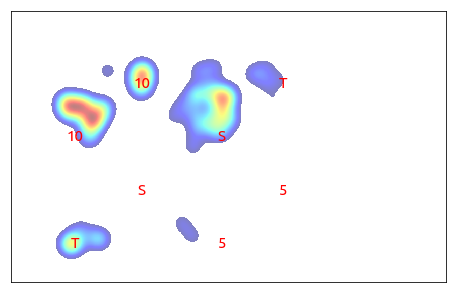

In [21]:
sub = 5
trial = 1
sub_fix = pd.read_csv(base_dir + '/Study2_EyeTracking/Data/Cleaned/Gaze_events/sub-%03d_fixations.csv'%sub,
                     index_col = 0)
trial_fix = sub_fix.query('trial == @trial')
trial_fix = trial_fix.loc[(trial_fix['x'] >= 200) & (trial_fix['x'] <= 1120) &
                          (trial_fix['y'] >= 200) & (trial_fix['y'] <= 950),:].reset_index(drop=True)
heatmap = get_heatmap(trial_fix, dispsize)
plot_heatmap(heatmap, dispsize, draw_numbers = True)

## Concatenate all subject fixations

In [17]:
subs = np.arange(5,55)
trials = np.arange(1,129)
eyes = ['L','R']
dispsize = [1680, 1050]

In [23]:
# all_fix = pd.DataFrame()
# for sub in subs:
#     sub_fix = pd.read_csv(base_dir + '/Study2_EyeTracking/Data/Cleaned/Gaze_events/sub-%03d_fixations.csv'%sub,
#                      index_col = 0)
#     all_fix = all_fix.append(sub_fix).reset_index(drop=True)

# all_fix['block'] = all_fix['trial'].apply(lambda x: np.floor((x-0.001)/16) + 1)

# block_pt_all = pd.DataFrame()
# for sub in all_fix['sub'].unique():
#     block_pt = load_block_pt(sub)
#     block_pt_all = block_pt_all.append(block_pt).reset_index(drop=True)

# all_fix = all_fix.merge(block_pt_all, on = ['sub','block'])
# all_fix.head()

# all_fix.to_csv(base_dir + '/Study2_EyeTracking/Data/Cleaned/Gaze_events/all_fixations.csv')